# Analysis of the autism data

In [4]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


* This section aims at answering a few questions related to the different algorithms used, with the aim of optimizing our classification framework.

**Parameters or potential settings**

* The approach used, which could be Logistic Regression, Decision Tree, Explainable Boosting Machine, Neural Additive models, or XGBoost.
* The use or not of indicator variables as inputs. 
* The scaling of the data. 
* The imputation approach when the learning algorithms does not handle them by design. It could be constant imputation (called encoding here), or conditional imputation (mean, knn, or mice).
* The sampling method in the case of imbalance learning (either no down-sampling, vanilla (random sampling of the minority class until classes are balanced), or SMOTE (a more elaborated sampling).
* The number of features, between 2 and 6. 
* The number of folds when cross-validating the results. 

**Notes on the classification pipeline:**

* Two datasets are age-matched but one (scenario `asd_td_age_matched_n_balanced`) lead to relatively balanced classes, whereas the scenario `asd_td_age_matched_n_unbalanced` has slightly younger kids and so leverage the amount of young neuro-typical kids, and is more unbalanced. 
* No searches on hyper-parameters are performed on each of the approach. Cross-validation is performed with the stratified inner-fold being left-out, the model is fitted on the training set, and the prediction of the test set is done with predictions stored for later evaluation of performances. 
* since a lot of settings parameters are tested, we test all of the hypothesis with a default setting that is: Encoding of the missing variables, scaling of the data, no use of indicator variables, no down-sampling (???), and a 16-fold cross-validation.
* Features selection were made for the two scenario suing the features with the higher importance based on xgboost importance map.
* Classification here is between autistic and neurotypical participants.



**Among the questions at stakes:**

* Experiment 1: Shall we use indicator variables? For each scenario (columns of axes), ad each dimension of the problem (rows of axes) , x is the `use_of_indicator_variables`, y is an indicator of performances (typically the F1 score), and the hue variable are the approaches. The plots are performed for no imputations, 
* Experiement 2: Shall we scale data or not ? 
* Experiment X: for the algorithms handling missing variables (xgboost, nam with encoding) , shall we let them be missing, or imputed ? 

## Experiment 1.  `use_missing_indicator_variables`

In [ ]:
approach = 'xgboost'

random_states = np.random.randint(0, 1000, K)
for random_state in random_states:
    for use_missing_indicator_variables in [False, USE_MISSING_INDICATOR_PREDICTORS]:

        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='diagnosis',
                        features_name = deepcopy(DEFAULT_PREDICTORS), 
                        scale_data=False,
                        use_missing_indicator_variables=use_missing_indicator_variables, 
                       verbosity=1,
                       scenario='multimodal_2023_regular',#'papers',
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          experiment_name = 'use_Z',
                           model_hyperparameters=xgboost_hyperparameters,
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)

        display(exp.performances_df)


## Experiment 2  `scale_data`

In [ ]:
random_states = np.random.randint(0, 1000, K)
for random_state in random_states:
    for scale_data in [True, False]:


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='diagnosis',
                        features_name = deepcopy(DEFAULT_PREDICTORS), 
                        scale_data=scale_data,
                        use_missing_indicator_variables=False, 
                       verbosity=0,
                       scenario='multimodal_2023_regular',#'papers',
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters,
                          experiment_name = 'Scale Data',
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Experiment 3. `Imputation approach`

In [ ]:
random_states = np.random.randint(0, 1000, K)
for random_state in random_states:

    for imputation_method in ['without','mice', 'knn', 'mean', 'constant']:

        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='imputation',
                       imputation_method=imputation_method,
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters,
                          experiment_name = 'Imputation',
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
    exp.fit_predict(num_cv=10, random_state=random_state)
    display(exp.performances_df)

## Experiment 4. `Sampling approach`

In [ ]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for sampling_method in ['without', 'vanilla', 'smote', 'scale_pos_weight']:

        if sampling_method == 'scale_pos_weight':

            xgboost_hyperparameters_experiment['scale_pos_weight'] = True
        else:
            xgboost_hyperparameters_experiment['scale_pos_weight'] = False

        if sampling_method == 'smote':
            missing_data_handling='imputation'
            imputation_method='constant'
        else:
            missing_data_handling='without'
            imputation_method='without'



        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling=missing_data_handling,
                       imputation_method=imputation_method,
                       sampling_method=sampling_method,
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'Sampling',
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Experiment 5. `n_estimators`

In [ ]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for n_estimators in [5, 10, 25, 50, 75, 100, 200, 500, 1000]:

        xgboost_hyperparameters_experiment['n_estimators'] = n_estimators


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'n_estimators',
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
    display(exp.performances_df)

## Experiment 6. `Depth`

In [ ]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for max_depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:

        xgboost_hyperparameters_experiment['max_depth'] = max_depth


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'max_depth',
                          verbosity=0, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Experiment 7. `gamma`

In [ ]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for gamma in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:

        xgboost_hyperparameters_experiment['gamma'] = gamma


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'gamma',
                          verbosity=0, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Experiment 8. `reg_lambda`

In [ ]:
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for reg_lambda in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:

        xgboost_hyperparameters_experiment['reg_lambda'] = reg_lambda


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'reg_lambda',
                          verbosity=0, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Experiment 9. `learning_rate`

In [ ]:
approach = 'xgboost'
xgboost_hyperparameters_experiment = deepcopy(xgboost_hyperparameters)
random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    for learning_rate in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:

        xgboost_hyperparameters_experiment['learning_rate'] = learning_rate


        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='without',
                       imputation_method='without',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS),
                       scale_data=False, 
                       use_missing_indicator_variables=False,
                       verbosity=1, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach=approach, 
                          previous_experiment=None,        
                          debug=False, 
                          model_hyperparameters=xgboost_hyperparameters_experiment,
                          experiment_name = 'learning_rate',
                          verbosity=1, 
                          experiment_folder_name='8_December', 
                          save_experiment=True)
        exp.fit_predict(num_cv=10, random_state=random_state)
        display(exp.performances_df)

## Custom parameters search in light of the performances results 

In [ ]:
K=25

In [ ]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

results_multiple = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='without',
                   imputation_method='without',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple = results_multiple.append(exp.performances_df)

In [ ]:
pd.DataFrame(results_multiple.mean()).transpose()

In [ ]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,
                            'max_depth' : 3,
                            'learning_rate' : 0.25, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

results_multiple_lr25 = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='without',
                   imputation_method='without',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple_lr25 = results_multiple_lr25.append(exp.performances_df)

In [ ]:
pd.DataFrame(results_multiple_lr25.mean()).transpose()

In [ ]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,
                            'max_depth' : 3,
                            'learning_rate' : 0.25, 
                            'gamma': 0,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0}

results_multiple_lr25_noreg = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='without',
                   imputation_method='without',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple_lr25_noreg = results_multiple_lr25_noreg.append(exp.performances_df)

In [ ]:
pd.DataFrame(results_multiple_lr25_noreg.mean()).transpose()

In [ ]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,
                            'max_depth' : 5,
                            'learning_rate' : 0.25, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

results_multiple_lr25_reg = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='without',
                   imputation_method='without',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple_lr25_reg = results_multiple_lr25_reg.append(exp.performances_df)

In [ ]:
pd.DataFrame(results_multiple_lr25_reg.mean()).transpose()

In [ ]:
%%capture
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}

#results_multiple_lr25_reg = pd.DataFrame(columns = exp.performances_df.columns)

random_states = np.random.randint(0, 1000, K)

for random_state in random_states[-10:]:
    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='8_December', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal All',
                      verbosity=1, 
                      save_experiment=False)

    exp.fit_predict(num_cv=10, random_state=random_state)
    
    display(exp.performances_df)
        
    results_multiple_lr25_reg = results_multiple_lr25_reg.append(exp.performances_df)

In [ ]:
pd.DataFrame(results_multiple_lr25_reg.mean()).transpose()

## Experiment 10. Test with all set of features

In [ ]:
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
K = 100

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:
    for feature_scenario in DEFAULT_PREDICTORS_BY_TYPES.keys():

        df =  pd.read_csv(AUTISM_DATA_PATH)

        data = Dataset(df=df, 
                       missing_data_handling='imputation',
                       imputation_method='constant',
                       sampling_method='without',
                       scenario = 'multimodal_2023_regular', 
                       features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES[feature_scenario]),
                       scale_data=False, 
                       use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
                       verbosity=0, 
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                          dataset=data, 
                          approach='xgboost', 
                          previous_experiment=None,        
                          debug=False, 
                          experiment_folder_name='Multimodal_paper_final_cva_experiment', 
                          model_hyperparameters=xgboost_hyperparameters,
                          experiment_name = 'Multimodal {}'.format(feature_scenario),
                          verbosity=0, 
                          save_experiment=True)

        exp.fit_predict(num_cv=5, sample_weight=weighted_confidence_score, random_state=random_state)
        #display(exp.performances_df)
        
print("Done")

# Experiment modifying the Postural Sway (as it is unexpected adding it decrease the perfromaces)

In [87]:
DEFAULT_PREDICTORS = [# GAZE RELATED
                 'mean_gaze_percent_right', #aggregated
                 'gaze_silhouette_score', #aggregated
                 'FP_gaze_speech_correlation',
    
                # NAME CALL RELATED
                 'proportion_of_name_call_responses',
                 'average_response_to_name_delay',

    
                # POSTURAL SWAY RELATED
                # 'S_postural_sway',  #aggregated
                # 'NS_postural_sway',  #aggregated
                 
                # 'S_postural_sway_complexity', 
                # 'NS_postural_sway_complexity',    
    
                 
                 # Facing Forward
                 'S_facing_forward', 
                 'NS_facing_forward', 
                 
                 # Facial complexity
                 'S_eyebrows_complexity', 
                 'NS_eyebrows_complexity', 
                 'S_mouth_complexity', 
                 'NS_mouth_complexity',
                 
                # TOUCH RELATED
                'pop_rate', 'std_error', 'average_length', 'average_force_applied']
                #'std_error','number_of_touches','number_of_target','average_error']

    
DEFAULT_PREDICTORS_BY_TYPES = {'All': DEFAULT_PREDICTORS,
                               'All - PosturalSway': ['mean_gaze_percent_right', 'gaze_silhouette_score', 'FP_gaze_speech_correlation',
                                              'proportion_of_name_call_responses','average_response_to_name_delay',
                                               'pop_rate', 'std_error', 'average_length', 'average_force_applied',
                                              'S_eyebrows_complexity', 'NS_eyebrows_complexity',
                                                'S_mouth_complexity', 'NS_mouth_complexity',
                                                'S_facing_forward', 'NS_facing_forward']
                               
                              }

In [98]:
from itertools import chain, combinations

stuff = ['S_postural_sway',  #aggregated
                 'NS_postural_sway',  #aggregated
                 'S_postural_sway_derivative',
                 'NS_postural_sway_derivative',
                 
                 'S_postural_sway_complexity', 
                 'NS_postural_sway_complexity']
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(1, len(ss)+1)))


    
    


In [108]:

random_states = np.random.randint(0, 1000, K)
for i, subset in enumerate(all_subsets(stuff)):
    if i == 2:
        print(subset)

('S_postural_sway_derivative',)


In [112]:
DEFAULT_PREDICTORS_BY_TYPES['All'] + list(subset)

['mean_gaze_percent_right',
 'gaze_silhouette_score',
 'FP_gaze_speech_correlation',
 'proportion_of_name_call_responses',
 'average_response_to_name_delay',
 'S_postural_sway',
 'NS_postural_sway',
 'S_postural_sway_derivative',
 'NS_postural_sway_derivative',
 'S_postural_sway_complexity',
 'NS_postural_sway_complexity',
 'S_facing_forward',
 'NS_facing_forward',
 'S_eyebrows_complexity',
 'NS_eyebrows_complexity',
 'S_mouth_complexity',
 'NS_mouth_complexity',
 'pop_rate',
 'std_error',
 'average_length',
 'average_force_applied',
 'S_postural_sway',
 'NS_postural_sway']

In [119]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.3, 
                            'gamma': 1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 1}

use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
K = 25
j=60
random_states = np.random.randint(0, 1000, K)
#for i, subset in enumerate(all_subsets(stuff)):
subset = ['S_postural_sway', 'NS_postural_sway']


#for feature_scenario in DEFAULT_PREDICTORS_BY_TYPES.keys():
for random_state in random_states:


    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = DEFAULT_PREDICTORS_BY_TYPES[feature_scenario] + list(subset), # if feature_scenario=='All' else DEFAULT_PREDICTORS_BY_TYPES[feature_scenario],
                   scale_data=False, 
                   use_missing_indicator_variables=False,
                   verbosity=0, 
                   proportion_train=1)


    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='20_december_features_experiment_with_weight_ps_test_final_90', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal {}'.format(feature_scenario),
                      verbosity=0, 
                      save_experiment=True)

    exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=random_state)
    #display(exp.performances_df)

print("Done")

Done


In [120]:
from utils import create_autism_df


df = create_autism_df(folder_names = ['20_december_features_experiment_with_weight_ps_test_final_90'])##'13_november_bis'])#'November 2022'])

100%|██████████| 26/26 [00:06<00:00,  4.32it/s]


In [121]:
len(df)

25

In [122]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'Hanley_CI'])

metrics_of_interest = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity','PPV-Corr', 'TP', 'TN', 'FP', 'FN']
metrics_to_plot = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity', 'PPV-Corr']#, 'Precision Corrected']

for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                      }, ignore_index=True)
        


In [123]:
results = results_df_vertical[(results_df_vertical['experiment_name'].str.contains('Multimodal')) & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results['experiment_name'] = results['experiment_name'].apply(lambda x: x.replace('Multimodal ', ''))
results['experiment_name'] = results['experiment_name'].replace({name: name.replace('-', 'but\n') if '-' in name else 
                                                                 name.replace('but', 'but\n') if 'but' in name else 
                                                                 name.replace('but', 'but\n') for name in results['experiment_name'].unique()})
results['experiment_name'].unique()
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

In [124]:
results[results['experiment_name'].isin(['All', 'All but\n PosturalSway'])].groupby(['experiment_name', 'metric_name']).describe()['score']

count     mean       std    min    25%    50%    75%    max
experiment_name        metric_name                                                                    
All but\n PosturalSway AUROC                25.0  0.88652  0.008685  0.870  0.882  0.885  0.892  0.907
                       F1 score Corrected   25.0  0.17720  0.027430  0.138  0.155  0.174  0.195  0.239
                       PPV-Corr             25.0  0.09640  0.017163  0.071  0.083  0.094  0.107  0.138
                       Sensitivity          25.0  0.83104  0.051261  0.694  0.816  0.837  0.857  0.898
                       Specificity          25.0  0.81116  0.044179  0.735  0.774  0.814  0.838  0.890

In [94]:
results[results['experiment_name'].isin(['All', 'All but\n PosturalSway'])].groupby(['experiment_name', 'metric_name']).describe()['score']

count      mean       std    min      25%     50%      75%    max
experiment_name        metric_name                                                                          
All                    AUROC                54.0  0.893093  0.007349  0.879  0.88825  0.8935  0.89900  0.906
                       F1 score Corrected   54.0  0.202741  0.026256  0.141  0.18375  0.2015  0.22400  0.255
                       PPV-Corr             54.0  0.112056  0.016525  0.073  0.09900  0.1110  0.12625  0.148
                       Sensitivity          54.0  0.832704  0.034168  0.755  0.81600  0.8370  0.85700  0.898
                       Specificity          54.0  0.841833  0.032197  0.741  0.82150  0.8410  0.86600  0.896
All but\n PosturalSway AUROC                50.0  0.898980  0.007588  0.885  0.89300  0.8970  0.90400  0.916
                       F1 score Corrected   50.0  0.228240  0.025629  0.173  0.21000  0.2325  0.24100  0.291
                       PPV-Corr             50.0  0.128180  0.016324  0.094  0.11700  0.1290  0.13800  0.169
                       Sensitivity          50.0  0.821240  0.034919  0.714  0.81600  0.8370  0.83700  0.878
                       Specificity          50.0  0.867280  0.023381  0.808  0.85400  0.8720  0.88025  0.912

In [12]:
results[results['experiment_name'].isin(['All', 'All but\n PosturalSway'])].groupby(['experiment_name', 'metric_name']).describe()['score']

count     mean       std    min      25%     50%      75%    max
experiment_name        metric_name                                                                         
All                    AUROC                50.0  0.88702  0.006570  0.875  0.88225  0.8885  0.89075  0.904
                       F1 score Corrected   50.0  0.18488  0.030002  0.126  0.16425  0.1820  0.19900  0.272
                       PPV-Corr             50.0  0.10142  0.019019  0.066  0.08825  0.0995  0.11075  0.159
                       Sensitivity          50.0  0.82576  0.037318  0.735  0.79600  0.8370  0.85700  0.898
                       Specificity          50.0  0.82294  0.039767  0.704  0.79600  0.8230  0.84725  0.909
All but\n PosturalSway AUROC                50.0  0.89104  0.007412  0.874  0.88700  0.8910  0.89575  0.907
                       F1 score Corrected   50.0  0.21298  0.029010  0.154  0.19000  0.2190  0.23200  0.278
                       PPV-Corr             50.0  0.11884  0.018661  0.082  0.10350  0.1235  0.13125  0.157
                       Sensitivity          50.0  0.82042  0.033471  0.755  0.79600  0.8160  0.85200  0.878
                       Specificity          50.0  0.85386  0.030452  0.784  0.83050  0.8645  0.87500  0.905

## Exerpiemnts on the Touch

In [46]:
DEFAULT_PREDICTORS = [# GAZE RELATED
                 'mean_gaze_percent_right', #aggregated
                 'gaze_silhouette_score', #aggregated
                 'FP_gaze_speech_correlation',
    
                # NAME CALL RELATED
                 'proportion_of_name_call_responses',
                 'average_response_to_name_delay',

    
                # POSTURAL SWAY RELATED
                 'S_postural_sway',  #aggregated
                 'NS_postural_sway',  #aggregated
                 'S_postural_sway_derivative',
                 'NS_postural_sway_derivative',
                 
                 'S_postural_sway_complexity', 
                 'NS_postural_sway_complexity',
                 
                 # Facing Forward
                 'S_facing_forward', 
                 'NS_facing_forward', 
                 
                 # Facial complexity
                 'S_eyebrows_complexity', 
                 'NS_eyebrows_complexity', 
                 'S_mouth_complexity', 
                 'NS_mouth_complexity',
                 
                # TOUCH RELATED
                #'pop_rate', 'average_error', 'average_length', 'average_force_applied']
                'pop_rate', 'std_error', 'average_length', 'average_force_applied']

                #'std_error','number_of_touches','number_of_target','average_error']

xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
    
use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
K = 50

random_states = np.random.randint(0, 1000, K)

for random_state in random_states:

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   features_name = DEFAULT_PREDICTORS,
                   scale_data=False, 
                   use_missing_indicator_variables=None,#USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=0, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='17_december_final_multomodal', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = 'Multimodal {}'.format(feature_scenario),
                      verbosity=0, 
                      save_experiment=True)

    exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=random_state)
    #display(exp.performances_df)

print("Done")

377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Done


**Baseline Results with std_error','number_of_touches','number_of_target','average_error'**

In [10]:


from utils import create_autism_df

df = create_autism_df(folder_names = ['15_December_final_regular_weighted_K50'])#'13_november_bis'])#'November 2022'])
#df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))
df[['AUROC', 'Sensitivity', 'Specificity']].mean()

100%|██████████| 51/51 [00:13<00:00,  3.72it/s]


AUROC          0.87788
Sensitivity    0.80820
Specificity    0.82022
dtype: float64

### Result with Clinical Profile variables

In [18]:
df = create_autism_df(folder_names = ['15_december_touch_experiment_clinical_profile_features'])#'13_november_bis'])#'November 2022'])
#df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))
df[['AUROC', 'Sensitivity', 'Specificity']].mean()

100%|██████████| 25/25 [00:06<00:00,  3.77it/s]


AUROC          0.866167
Sensitivity    0.818250
Specificity    0.786375
dtype: float64

In [19]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/15_december_touch_experiment_clinical_profile_features/SenseToKnow/'
json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)
shap_values = shap_interactions.sum(axis=2)
shap_values_n = shap_values / np.abs(shap_values).sum(axis=2)[:, :, np.newaxis]

shap_values_averaged_n = shap_values_averaged / np.abs(shap_values_averaged).sum(axis=1)[:, np.newaxis]

mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_averaged_n, mask_shap_present)
shap_missing = np.multiply(shap_values_averaged_n, (mask_shap_present==0).astype(int))

general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
general_shap_values_normalized = np.abs(general_shap_values)/ np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
features_importances_extended = general_shap_values_normalized.sum(axis=0)/general_shap_values_normalized.sum()


labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]       
n_features = len(exp.features_name)

#We first plot the present ones
idx_sorting_present = list(reversed(np.argsort(features_importances_extended[:n_features])))

fi(35, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(np.array(exp.features_name)[idx_sorting_present]):
    plt.bar(i, features_importances_extended[idx_sorting_present][i], color='tab:blue')
    
idx_sorting_missing = list(reversed(np.argsort(features_importances_extended[n_features:])))
idx_sorting_missing = list(np.array(idx_sorting_missing) + n_features)
#And then the missing ones
for i, feat in enumerate(np.array(labels)[idx_sorting_missing]):
    j = i + n_features
    plt.bar(j, features_importances_extended[idx_sorting_missing][i], color='tab:blue')
    
    
idx_sorting = idx_sorting_present + idx_sorting_missing
plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=np.array(labels)[idx_sorting], rotation =90)
None


#percent_missing_importance_mean = (1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).mean()*100
#percent_missing_importance_std =(1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).std()*100

#print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

(24, 377, 25, 25)

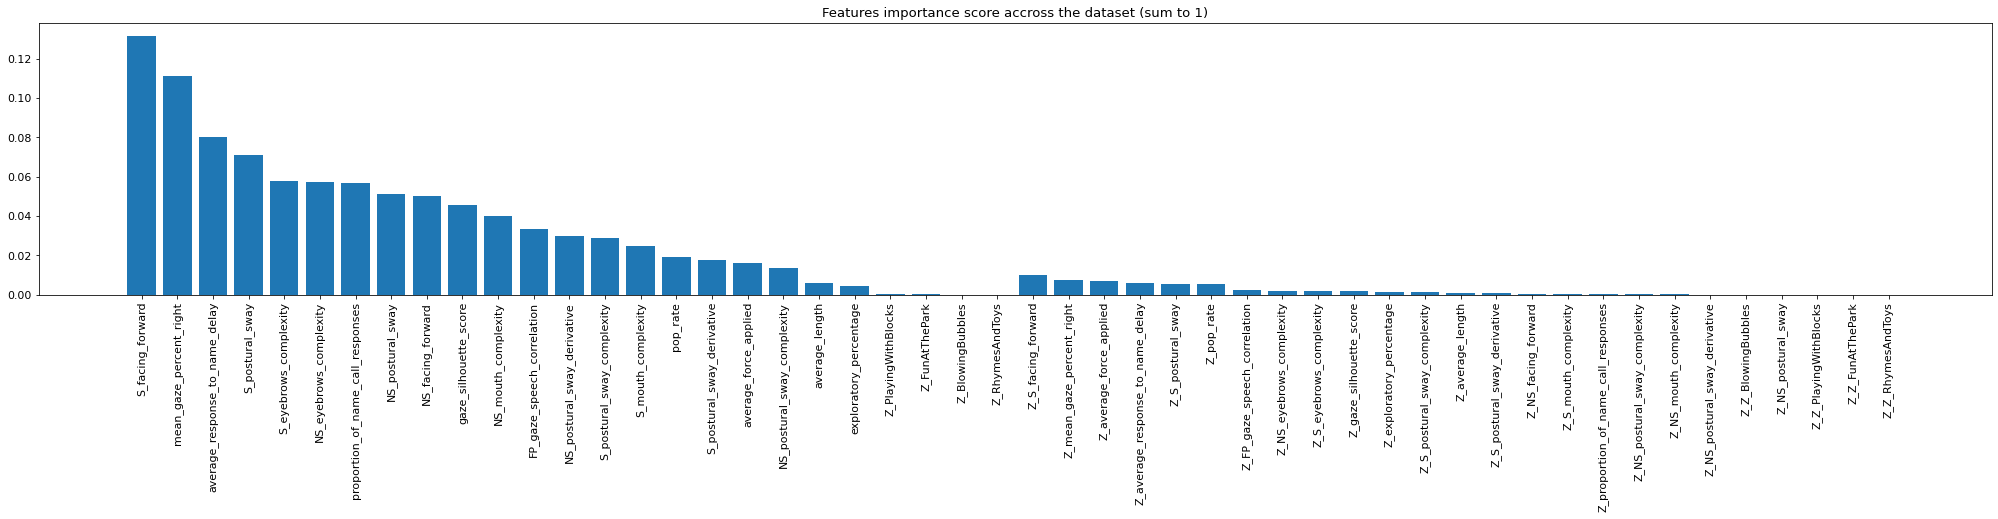

### Result with Clinical Profile variables with explora replace with error

In [41]:
df = create_autism_df(folder_names = ['15_december_touch_experiment_clinical_profile_features_explo_to_error'])#'13_november_bis'])#'November 2022'])
#df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))
df[['AUROC', 'Sensitivity', 'Specificity']].mean()

100%|██████████| 26/26 [00:06<00:00,  3.81it/s]


AUROC          0.86860
Sensitivity    0.81724
Specificity    0.78404
dtype: float64

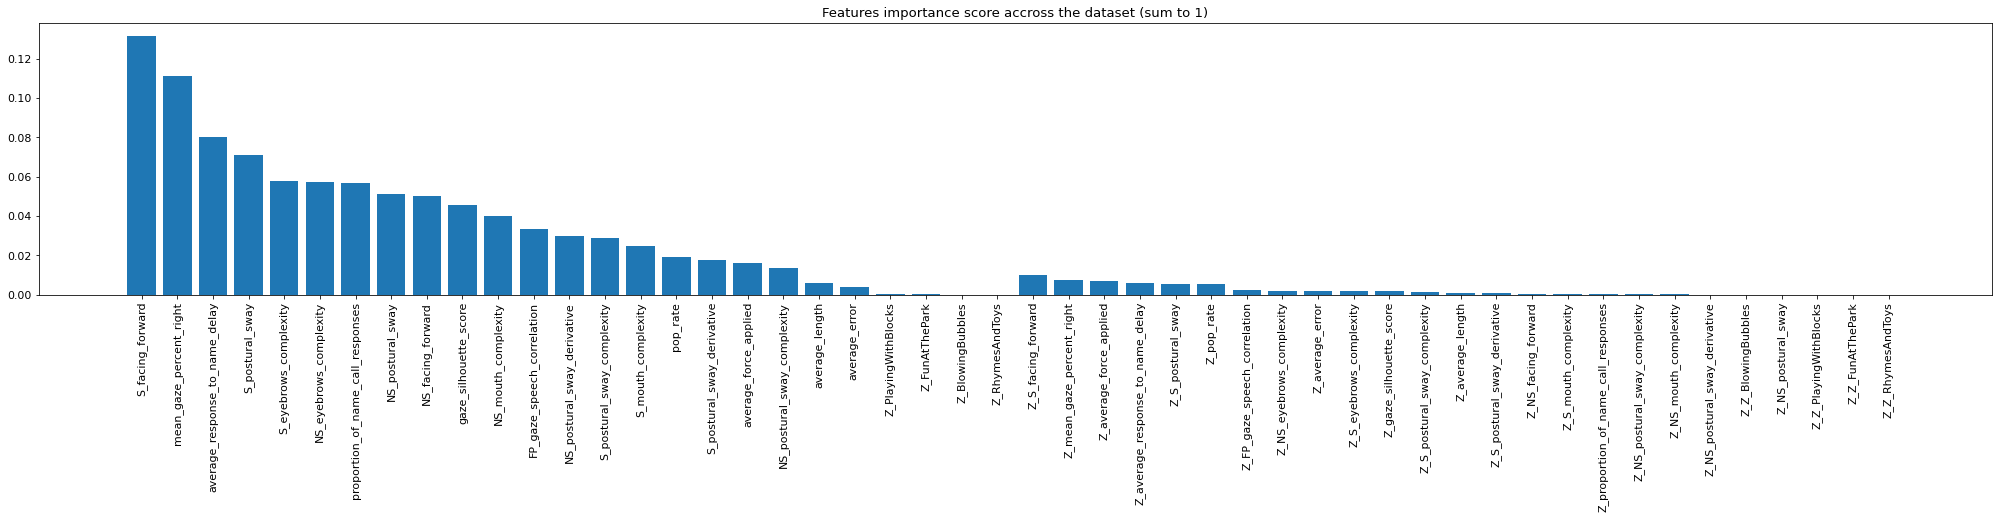

In [42]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/15_december_touch_experiment_clinical_profile_features_explo_to_error/SenseToKnow/'
json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)
shap_values = shap_interactions.sum(axis=2)
shap_values_n = shap_values / np.abs(shap_values).sum(axis=2)[:, :, np.newaxis]
shap_values_averaged = shap_values_n.mean(axis=0)
shap_values_averaged_n = shap_values_averaged / np.abs(shap_values_averaged).sum(axis=1)[:, np.newaxis]

mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_averaged_n, mask_shap_present)
shap_missing = np.multiply(shap_values_averaged_n, (mask_shap_present==0).astype(int))

general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
general_shap_values_normalized = np.abs(general_shap_values)/ np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
features_importances_extended = general_shap_values_normalized.sum(axis=0)/general_shap_values_normalized.sum()


labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]       
n_features = len(exp.features_name)

#We first plot the present ones
idx_sorting_present = list(reversed(np.argsort(features_importances_extended[:n_features])))

fi(35, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(np.array(exp.features_name)[idx_sorting_present]):
    plt.bar(i, features_importances_extended[idx_sorting_present][i], color='tab:blue')
    
idx_sorting_missing = list(reversed(np.argsort(features_importances_extended[n_features:])))
idx_sorting_missing = list(np.array(idx_sorting_missing) + n_features)
#And then the missing ones
for i, feat in enumerate(np.array(labels)[idx_sorting_missing]):
    j = i + n_features
    plt.bar(j, features_importances_extended[idx_sorting_missing][i], color='tab:blue')
    
    
idx_sorting = idx_sorting_present + idx_sorting_missing
plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=np.array(labels)[idx_sorting], rotation =90)
None


#percent_missing_importance_mean = (1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).mean()*100
#percent_missing_importance_std =(1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).std()*100

#print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

### Result with Clinical Profile variables with cutom

In [44]:
df = create_autism_df(folder_names = ['15_december_touch_experiment_clinical_profile_features_custom'])#'13_november_bis'])#'November 2022'])
#df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))
df[['AUROC', 'Sensitivity', 'Specificity']].mean()

100%|██████████| 26/26 [00:06<00:00,  3.85it/s]


AUROC          0.87988
Sensitivity    0.81232
Specificity    0.81892
dtype: float64

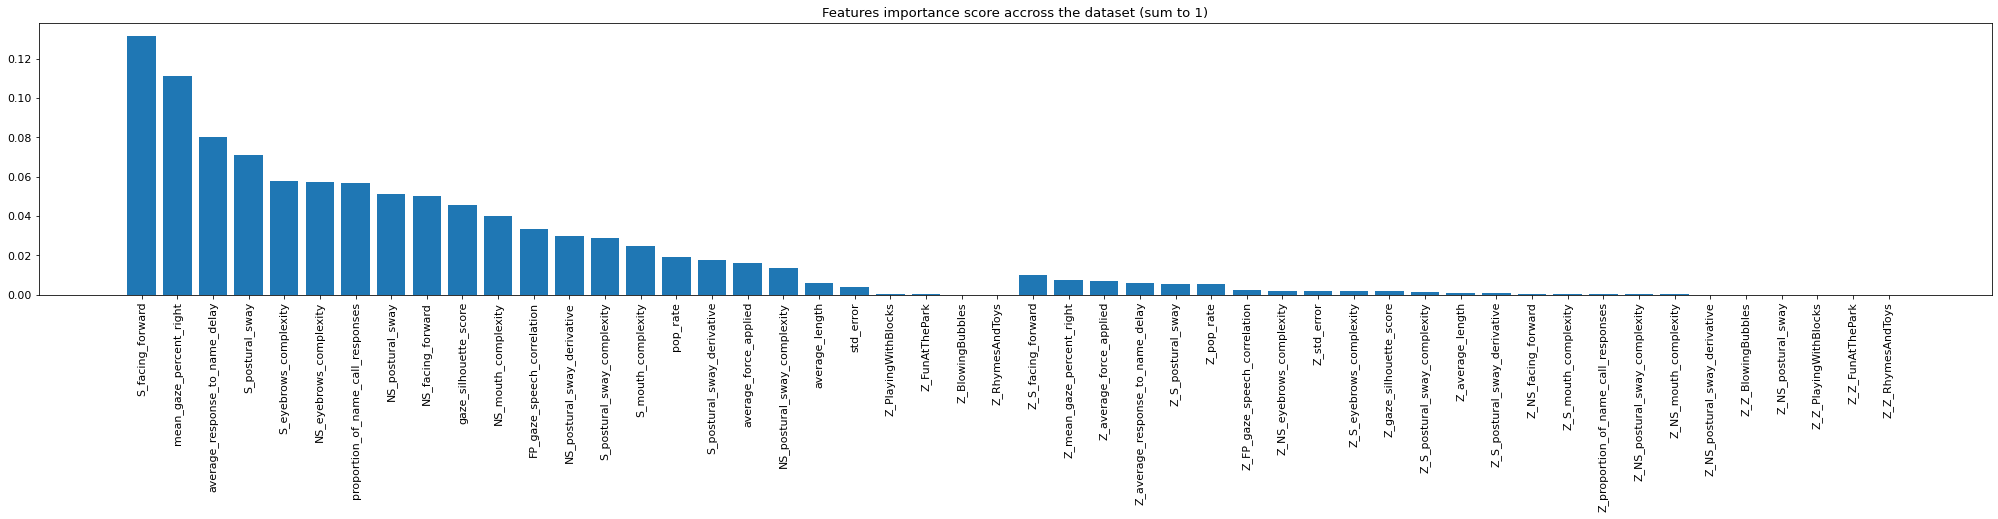

In [45]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/15_december_touch_experiment_clinical_profile_features_custom/SenseToKnow/'
json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)
shap_values = shap_interactions.sum(axis=2)
shap_values_n = shap_values / np.abs(shap_values).sum(axis=2)[:, :, np.newaxis]

shap_values_averaged_n = shap_values_averaged / np.abs(shap_values_averaged).sum(axis=1)[:, np.newaxis]

mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_averaged_n, mask_shap_present)
shap_missing = np.multiply(shap_values_averaged_n, (mask_shap_present==0).astype(int))

general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
general_shap_values_normalized = np.abs(general_shap_values)/ np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
features_importances_extended = general_shap_values_normalized.sum(axis=0)/general_shap_values_normalized.sum()


labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]       
n_features = len(exp.features_name)

#We first plot the present ones
idx_sorting_present = list(reversed(np.argsort(features_importances_extended[:n_features])))

fi(35, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(np.array(exp.features_name)[idx_sorting_present]):
    plt.bar(i, features_importances_extended[idx_sorting_present][i], color='tab:blue')
    
idx_sorting_missing = list(reversed(np.argsort(features_importances_extended[n_features:])))
idx_sorting_missing = list(np.array(idx_sorting_missing) + n_features)
#And then the missing ones
for i, feat in enumerate(np.array(labels)[idx_sorting_missing]):
    j = i + n_features
    plt.bar(j, features_importances_extended[idx_sorting_missing][i], color='tab:blue')
    
    
idx_sorting = idx_sorting_present + idx_sorting_missing
plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=np.array(labels)[idx_sorting], rotation =90)
None


#percent_missing_importance_mean = (1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).mean()*100
#percent_missing_importance_std =(1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).std()*100

#print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

In [47]:
df = create_autism_df(folder_names = ['15_december_touch_experiment_clinical_profile_features_custom_no_Z'])#'13_november_bis'])#'November 2022'])
#df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))
df[['AUROC', 'Sensitivity', 'Specificity']].mean()

100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


AUROC          0.87808
Sensitivity    0.81564
Specificity    0.81572
dtype: float64

# Exepriment. Classification using Z variables only (are missing watching stimulis potential predictors ?)

In [2]:
# Number of experiments when doing the CV
K = 25

In [3]:
dict_missing_stimulis = {'PopTheBubbles': ['number_of_touches'],
                         'FloatingBubbles': ['FB_postural_sway', 'FB_postural_sway_derivative'],
                            'DogInGrassC': ['DIGC_postural_sway', 'DIGC_postural_sway_derivative'],
                            'DogInGrassRRL': ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
                            'SpinningTop': ['ST_postural_sway', 'ST_postural_sway_derivative'],
                            'PlayingWithBlocks': ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
                            'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative',
                                                'FP_gaze_speech_correlation', 'FP_gaze_silhouette_score'],
                             'MechanicalPuppy': ['MP_postural_sway', 'MP_postural_sway_derivative'],
                             'BlowingBubbles': ['BB_postural_sway', 'BB_postural_sway_derivative',
                                                   'BB_gaze_percent_right', 'BB_gaze_percent_right'],
                            'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative'],
                             'MakeMeLaugh': ['MML_postural_sway', 'MML_postural_sway_derivative'],
                             'RTNDelay': ['average_response_to_name_delay']}

In [4]:
df =  pd.read_csv(AUTISM_DATA_PATH)

for feature_name_grouped, feats in dict_missing_stimulis.items():
    df['Z_{}'.format(feature_name_grouped)] = 0
    df.loc[df.drop(index=df.dropna(subset=feats, how='any').index).index, 'Z_{}'.format(feature_name_grouped)] = 1

data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = ['Z_'+ i for i in dict_missing_stimulis.keys()], 
                scale_data=False,
                use_missing_indicator_variables=False, 
               verbosity=1,
               scenario='multimodal_2023_regular',#'papers',
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_name = 'Z_stimulis',
                   model_hyperparameters=xgboost_hyperparameters,
                  verbosity=3, 
                  experiment_folder_name='7_December', 
                  save_experiment=False)
exp.fit_predict(num_cv=10, random_state=100)

377 administrations left.


,id
diagnosis,
0.0,328
1.0,49


Predicting diagnosis based on 12 features using xgboost approach.
Performing 10 fold cross-validation.
10-fold Cross-Validation.
Size Train: 339 (295 NT 44 ASD) Test: 38 (33 NT 5 ASD)


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,Z_stimulis,0.431,0.159,0.046,0.034,0.712,0.428,0.044,0.428,0.104,0.135,-0.037,0.98,0.009,0.129,0.022,0.75,0.02,0.871,0.25,48,3,325,1


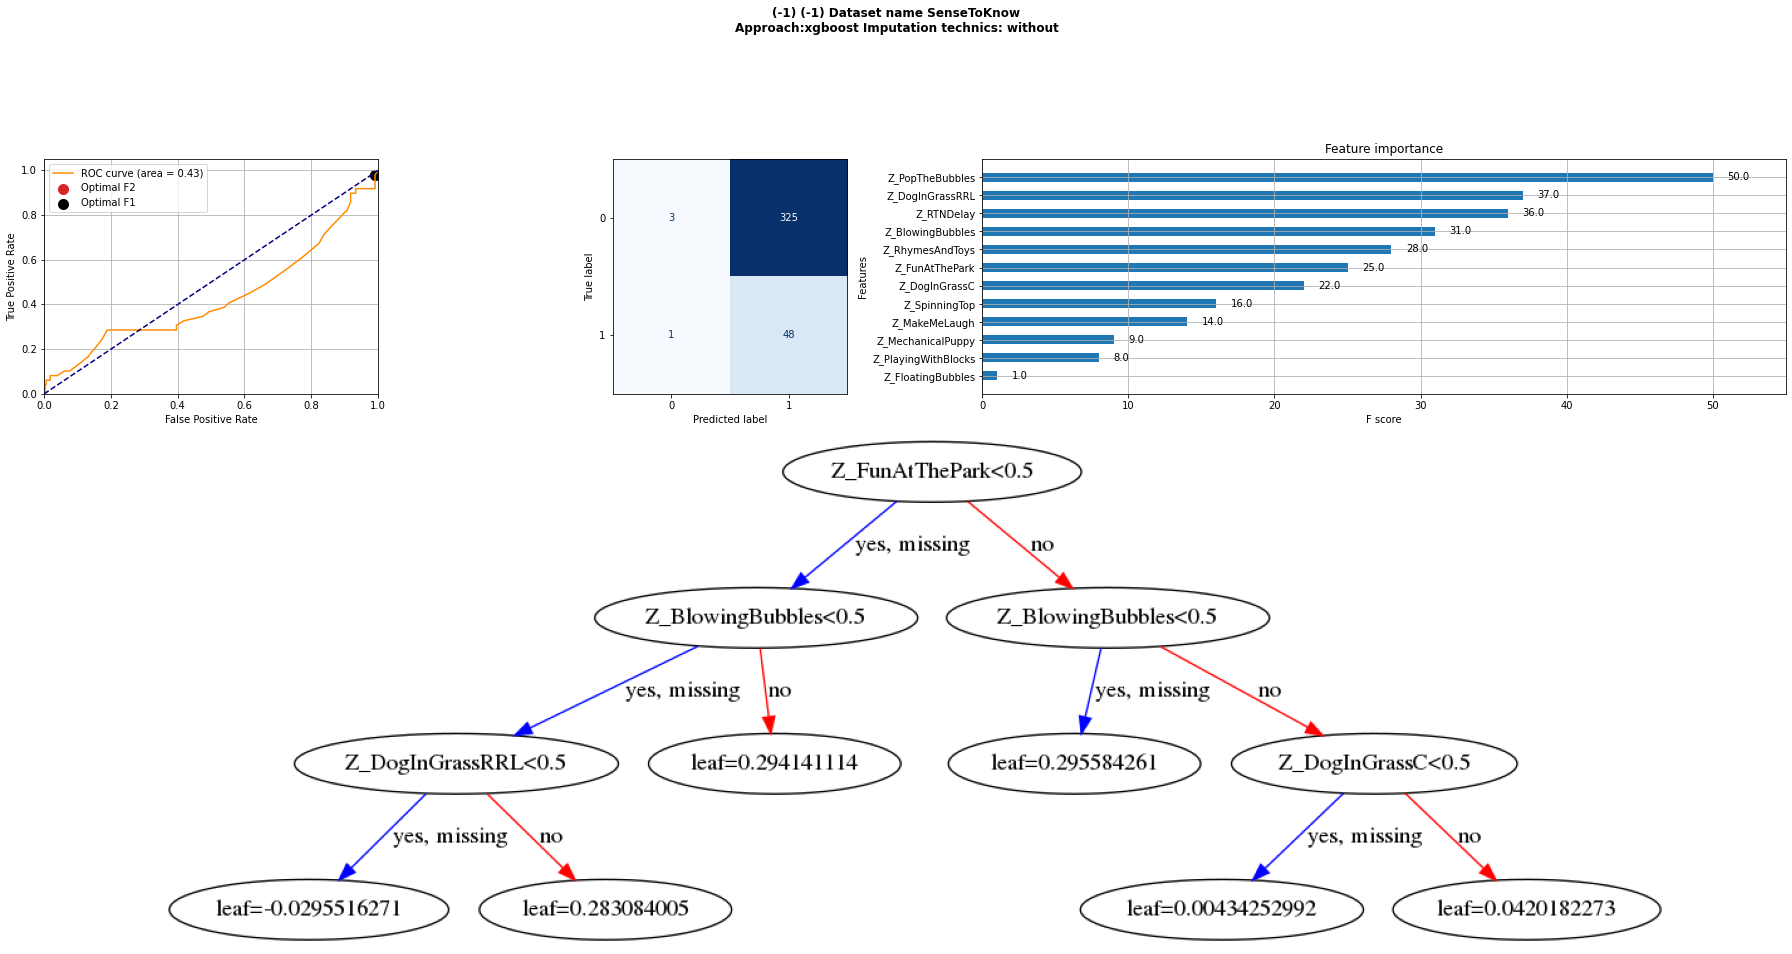

In [5]:
exp.plot()